# Modeling the Time Evolution of the Annualized Rate of Mass Shootings with Gaussian Processes

Nathan Sanders, Victor Lei (Legendary Entertainment)

December, 2016

License: [Creative Commons Attribution 4.0 International Public License](https://creativecommons.org/licenses/by/4.0/legalcode)

## Abstract

Much of the public policy debate over gun control and gun rights in the United States hinges on the alarming incidence of mass shootings, here defined as attacks killing four or more victims.  Several times in recent years, individual, highly salient mass shooting incidents have galvanized public discussion of reform efforts.  But deliberative legislative action proceeds over a much longer timescale that should be informed by knowledge of the long term evolution of these events.  We have used *Stan* to develop a new model for the annualized rate of mass shootings in the United States based on a Gaussian process with a time-varying mean function.  This design yields a predictive model with the full non-parametric flexibility of a Gaussian process, while retaining the direct interpretability of a parametric model for long-term evolution of the mass shooting rate.  We apply this model to the Mother Jones database of mass shootings and explore the posterior consequences of different prior choices and of correlations between hyperparameters.  We reach conclusions about the long term evolution of the rate of mass shootings in the United States and short-term periods deviating from this trend.

## Background

Tragic, high profile public events over the past few years like the shootings at the Washington Navy Yard; the Emanuel AME Church in Charleston; San Bernadino, CA; and Orlando, FL have raised public awareness of the dangers posed by mass shooting events and sociological interest in understanding the motivations and occurrence rates of such events.  There is no commonly accepted definition of a mass shooting, but such an event is generally understood to be the simultaneous homicide of multiple people perpetrated by an individual or coordinated group via firearm. 

A particular question facing elevated public, political, and scholarly scrutiny is whether the rate of mass shootings has increased significantly over recent years.  Lott (2014) responded to a [September, 2013 FBI report](https://www.fbi.gov/news/stories/2014/september/fbi-releases-study-on-active-shooter-incidents/pdfs/a-study-of-active-shooter-incidents-in-the-u.s.-between-2000-and-2013) on mass shootings by re-evaluating sources of bias, reviewing data consistency, and redefining the period under consideration to conclude that no statistically significant increase is identifiable.  Cohen et al. (2014) claim that the rate of mass shootings tripled over the four year period 2011-2014 based on a Statistical Process Control (SPC) analysis of the duration between successive events.

In this study, we present a new statistical approach to evaluating the time evolution of the rate of mass shootings.  We do not present original data on occurrences in the United States, address the myriad considerations inherent in defining a "mass shooting" event, or seek to resolve the causal issues of why the growth rate may have changed over time.  We do adopt a commonly cited mass shooting dataset and definition from Mother Jones.

We develop a Gaussian process-based model for the time evolution of the occurrence rate of mass shootings and demonstrate inference under this model by straightforward application of the probabilistic programming language *Stan*.  We use this case to explore the intersection of parametric and non-parametric models.  We seek to merge a parametric model, with straightforward interpretations of posterior marginalized parameter inferences, with a non-parametric model that captures and permits discovery of unspecified trends.  *Stan's* flexible modeling language permits rapid model design and iteration, while the No-U-Turn sampler allows us to fully explore the model posterior and understand the dependence between the parametric and non-parametric components of our model and the implications of our prior assumptions.

In the following notebook, we describe the Mother Jones dataset on US mass shootings and lay out our statistical model and inference scheme.  We then discuss the results from this inference, how they depend on choices for the prior distribution, and explore correlations between hyperparameters.  Finally, we discuss the conclusions that can be reached from inspection of the marginal posterior distributions.

In [1]:
## Notebook setup
%matplotlib inline

import pandas as pd
import numpy as np
import pickle, os, copy
import scipy
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator

## NOTE: As of PyStan 2.12.0.0, there is a known issue using the 
## new cov_exp_quad function.  It should be resolved in 2.13, 
## but for now we will wrap cmdstan using stanhelper instead.
##
## See https://github.com/akucukelbir/stanhelper

import pystan
import stanhelper
import subprocess
cmdstan_path = os.path.expanduser('~/Stan/cmdstan/')

from scipy import stats as sstats

### Package versions

In [2]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,scipy,matplotlib 
#,pystan

CPython 2.7.6
IPython 4.0.0

pandas 0.18.1
numpy 1.11.2
scipy 0.18.1
matplotlib 1.4.3

compiler   : GCC 4.8.2
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
print subprocess.check_output(cmdstan_path+'bin/stanc --version', shell=1)

stanc version 2.12.0



## Data

For this study, we consider the [database published by Mother Jones](http://www.motherjones.com/politics/2012/12/mass-shootings-mother-jones-full-data) (retrieved for this study on October 16, 2016}, compiling incidents of mass shootings in the United States from 1982 through September of 2016.  The database includes rich (quantitative and qualitative) metadata on the effects of the incidents, the mental health condition of the perpetrators, weapon type, how the perpetrators obtained their weapons, and more; however, we focus primarily on the dates of incident occurrence.  

The definition of a mass shooting is not universally agreed upon, and even when a firm definition is adopted there can be ambiguity in how to apply it to the complex and uncertain circumstances of these chaotic events.  See Fox & Levin (2015) for a recent discussion.  The criteria for inclusion in the Mother Jones database were described in a [2014 article by Mark Follman](http://www.motherjones.com/politics/2014/10/mass-shootings-rising-harvard):
	
> [The database] includes attacks in public places with four or more victims killed, a baseline established by the FBI a decade ago. We excluded mass murders in private homes related to domestic violence, as well as shootings tied to gang or other criminal activity.''

Follman discusses their motivations for these criteria and provide some examples of prominent incidents excluded by the criteria, such as the shooting at Ft. Hood in April, 2014.  Note that the federal threshold for investigation of mass shootings was lowered to three victim fatalities in January of 2013, and the Mother Jones database includes shootings under this more expansive definition starting from that date.  To maintain a consistent definition for mass shootings throughout the studied time period, we only consider shootings with four or more victim fatalities.

Our primary dataset is the count of incidents reported in this database per calendar year.  We include incidents labeled as both "Mass" or "Spree" by Mother Jones.

In [4]:
## Load data
data = pd.read_excel('MotherJonesData_2016_10_16.xlsx','US mass shootings')

## Stadardize on definition of fatalities at 4.  Mother Jones changed it to 3 in 2013.
data = data[data.Fatalities > 3]

## Prepare data
# Aggregate data anually
data_annual = data.groupby('Year')
# Count cases by year and fill in empty years
cases_resamp = data_annual.count().Case.ix[np.arange(1982,2017)].fillna(0)
# Enumerate years in range
data_years = cases_resamp.index.values
# Enumerate quarters across daterange for later plotting
data_years_samp = np.arange(min(data_years), max(data_years)+10, .25)
# Format for Stan
stan_data = {
	'N1': len(cases_resamp),
	'x1': data_years - min(data_years),
	'z1': cases_resamp.values.astype(int),
	'N2': len(data_years_samp),
	'x2': data_years_samp - min(data_years),
	}

In [5]:
for key in stan_data:
    print key
    print stan_data[key]
    print '\n'

x2
[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75   5.
   5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25   7.5
   7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75  10.    10.25
  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25  12.5   12.75  13.
  13.25  13.5   13.75  14.    14.25  14.5   14.75  15.    15.25  15.5
  15.75  16.    16.25  16.5   16.75  17.    17.25  17.5   17.75  18.    18.25
  18.5   18.75  19.    19.25  19.5   19.75  20.    20.25  20.5   20.75  21.
  21.25  21.5   21.75  22.    22.25  22.5   22.75  23.    23.25  23.5
  23.75  24.    24.25  24.5   24.75  25.    25.25  25.5   25.75  26.    26.25
  26.5   26.75  27.    27.25  27.5   27.75  28.    28.25  28.5   28.75  29.
  29.25  29.5   29.75  30.    30.25  30.5   30.75  31.    31.25  31.5
  31.75  32.    32.25  32.5   32.75  33.    33.25  33.5   33.75  34.    34.25
  34.5   34.75  35.    35.25  

In [6]:
## Number of years with data
print len(stan_data['x1'])

35


In [7]:
## Number of interpolated points to do prediction for
print len(stan_data['x2'])

176


## Statistical Model

We adopt a univariate Gaussian process model (see e.g. Rasmussen & Williams 2006) as a non-parametric description of the time evolution of the annualized occurrence rate.  The Gaussian process describes deviations from a mean function by a covariance matrix that controls the probability of the deviation as a function of the time differential between points.  Robers et al. (2012) surveyed applications of Gaussian process models to timeseries data, and explored the implications of different choices for the mean and covariance functions.

We adopt the following system of units for the Gaussian Process model.  The time vector $x$ is measured in years since 1982 and the outcome vector $\log(z)$ is defined as the natural logarithm of the number of occurrences.

Many applications of Gaussian processes adopt a constant, zero mean function.  In that case, the relationship between the dependent variable(s) and the predictors is described entirely by the non-parametric family of functions generated from the Gaussian process covariance function.  

We adopt a linear mean function and a squared-exponential covariance function.  The mean function $\mu(x)$ is simply:
	
\begin{equation}
\mu(x) = \mu_0 + \mu_b~x
\end{equation}

Note that the linear mean function for the outcome variable $\log(z)$ corresponds to an exponential function for the evolution of the number of shootings per year.  

The familiar squared-exponential covariance function, which generates infinitely-differentiable functions from the Gaussian process, is:

\begin{equation}
k(x)_{i,j} = \eta^2~exp \big( -\rho^2 \sum_{d=1}^{D}(x_{i,d} - x_{j,d})^2 \big) + \delta_{i,j}~\sigma^2
\end{equation}

where the hyperparameter $\eta$ controls the overall strength of covariance, $\rho$ controls the timescale over which functions drawn from the process vary, and $\sigma$ controls the baseline level of variance.

Our likelihood assumes that the logarithmic occurrence rate is specified by exponentiated draws of the occurrence rate $y$ from the mean and covariance functions, and the observed outcome data is negative binomial-distributed according to the rate.

\begin{align}
y(x) \sim \rm{N}(\mu(x), k(x)^2) \\
\log\big(z(x)\big) ~ \sim \rm{NB}(exp(y(x)), \phi)
\end{align}

where $\rm{N}$ is the normal (parameterized by the standard deviation rather than the variance, per *Stan* standard syntax) and $\rm{NB}$ is the negative binomial distribution.  We use the "alternative" parameterization of the negative binomial distribution described in the *Stan* manual, where the second parameter directly scales the overdispersion relative to a Poisson distribution.  While we choose the negative binomial to permit overdispersion in the annualized mass shooting rate beyond counting noise, as we will see, the data provide strong evidence for small values of $\phi^{-1}$, consistent with Poisson noise.

The role of each component of the Gaussian process will depend largely on the timescale parameter $\rho$.  When the timescale is short, the model effectively divides the response into a long-term (timescale of the range of the data; in this case, decades) parametric effect and a short-term (timescale of e.g. years) non-parametric effect.  This approach gives us the full flexibility of the Gaussian process for predictive applications, while still allowing us to make interpretable, parametric inferences on the long-term evolution of the system.  

We apply the following prior and hyperprior distributions to provide weak information about the scale of the relevant parameters in the adopted unit system:

\begin{align*}
\rho^{-1} \sim \Gamma(\alpha_{\rho}, \beta_{\rho})  \\
\eta^2 \sim \rm{C}(2. 5) \\
\sigma^2 \sim \rm{C}(0, 2.5)  \\
\mu_0 \sim \rm{N}(0, 2)  \\
\mu_b \sim \rm{N}(0, 0.2)  \\
\phi^{-1} \sim C(0, 5)
\end{align*}

where $\Gamma$ is the gamma distribution; $\rm{C}$ is the half-Cauchy distribution; the parameters $\eta^2$, $\sigma^2$, and $\phi^{-1}$ are constrained to be positive; and we apply the constraint $\rho^{-1} > 1$ to enforce timescales $>1$ yr (the spacing of our data).

Below we explore different choices for the $\alpha$ and $\beta$ parameters of the gamma hyperprior on $\rho^{-1}$, labeled as $\alpha_{\rho}$ and $\beta_{\rho}$. In particular, we explore $(\alpha_{\rho},\beta_{\rho}) = (4,1)$ and $(1,1/100)$.  These correspond to prior distributions with standard deviations of $2$ and $100$ years, respectively.  On top of the linear trend in the mean function, the former represents a strong prior expectation that the annualized rate of mass shootings evolves on a timescale of a few years, and the latter represents a nearly-flat expectation for variations on timescales from a few years to a few centuries.

We implement the Gaussian process model in *Stan*, adapting the logistic classification example in Section 14.5 of the *Stan* manual.  *Stan's* *NUTS* sampler performs full joint Bayesian estimation of all parameters, including the mean function parameters $\mu_0$ and $\mu_b$ and the Gaussian Process hyperparmeters $\eta$, $\rho$, and $\sigma$ and the negative binomial over-dispersion $\phi^{-1}$.  The $\alpha_{\rho}$ and $\beta_{\rho}$ hyperparameters of the $\rho$ hyperprior distribution are fixed.  We use the Cholesky factor transformed implementation of the normal distribution to calculate the likelihood. 

We expect these hyperparameters to be at least somewhat correlated and not well-identified, introducing significant curvature in the model posterior, indicating that Hamiltonian Monte Carlo (HMC) would be a particularly effective sampling strategy for this model (Betancourt & Girolami 2013).  We fit the model to the 35 annual observations of the Mother Jones dataset and do model interpolation and prediction over a grid of 176 quarters from 1980 to 2024.  

We typically fit 8 independent chains of length 2000 iterations (following an equal number of NUTS warmup samples) in parallel using *Stan* and observe a typical execution time of ~1 min.  For the purposes of this notebook, we obtain a larger number of samples by fitting 20 chains of 4000 samples in order to improve the resolution of 2D posterior histograms; the conclusions are qualitiatively unaffected.


In [8]:
## Full model in Stan code:
stan_code = """
data {
	int<lower=1> N1;
	vector[N1] x1;
	int z1[N1];
	int<lower=1> N2;
	vector[N2] x2;
	real<lower=0> alpha_rho;
	real<lower=0> beta_rho;
}
transformed data {
	int<lower=1> N;
	vector[N1+N2] x;
	// cov_exp_quad wants real valued inputs
	real rx[N1+N2]; 
	real rx1[N1];
	real rx2[N2];
	
	N = N1 + N2;
	for (n in 1:N1) x[n] = x1[n];
	for (n in 1:N2) x[N1 + n] = x2[n];
	
	for (n in 1:N) rx[n] = x[n];
	for (n in 1:N1) rx1[n] = x1[n];
	for (n in 1:N2) rx2[n] = x2[n];
}
parameters {
	vector[N1] y_tilde1;
	real<lower=0> eta_sq;
	real<lower=1> inv_rho;
	real<lower=1e-6> sigma_sq;
	real mu_0;
	real mu_b;
	real<lower=0> NB_phi_inv;
}
model {
	vector[N1] mu1;
	vector[N1] y1;
	matrix[N1,N1] Sigma1;
	matrix[N1,N1] L1;
	
	// Calculate mean function
	mu1 = mu_0 + mu_b * x1;

	// GP hyperpriors
	eta_sq ~ cauchy(0, 1);
	sigma_sq ~ cauchy(0, 1);
	inv_rho ~ gamma(alpha_rho, beta_rho); // Gamma prior with mean of 4 and std of 2
	
	// Calculate covariance matrix using new optimized function
	Sigma1 = cov_exp_quad(rx1, sqrt(eta_sq), sqrt(0.5) * inv_rho);
	for (n in 1:N1) Sigma1[n,n] = Sigma1[n,n] + sigma_sq;
	
	// Decompose
	L1 = cholesky_decompose(Sigma1);
	// We're using a the non-centered parameterization, so rescale y_tilde
	y1 = mu1 + L1 * y_tilde1;

	// Mean model priors
	mu_0 ~ normal(0, 2);
	mu_b ~ normal(0, 0.2);
	
	// Negative-binomial prior
	// For neg_binomial_2, phi^-1 controls the overdispersion.  phi^-1 ~ 0 reduces to the poisson.  phi^-1 = 1 represents variance = mu+mu^2
	NB_phi_inv ~ cauchy(0, 5);
	
	// Generate non-centered parameterization
	y_tilde1 ~ normal(0, 1);
	
	// Likelihood
	z1 ~ neg_binomial_2_log(y1, inv(NB_phi_inv));
}
generated quantities {
	vector[N1] y1;
	vector[N2] y2;
	vector[N] y;
	int z_rep[N];
	
	{
		// Don't save these parameters
		matrix[N,N] Sigma;
		matrix[N,N] L;
		vector[N] y_tilde;
		
		Sigma = cov_exp_quad(rx, sqrt(eta_sq), sqrt(0.5) * inv_rho);
		for (n in 1:N) Sigma[n,n] = Sigma[n,n] + sigma_sq;
		
		for (n in 1:N1) y_tilde[n] = y_tilde1[n];
        for (n in (N1 + 1):N) y_tilde[n] = normal_rng(0,1);
		
		// Decompose
		L = cholesky_decompose(Sigma);
		y = mu_0 + mu_b * x + L * y_tilde;

		for (n in 1:N1) y1[n] = y[n];
		for (n in 1:N2) y2[n] = y[N1+n];
		
		for (n in 1:N) z_rep[n] = neg_binomial_2_log_rng(y[n], inv(NB_phi_inv));
	}
}
"""

with open('gp_model_for_cmdstan.stan', 'w') as f:
    f.write(stan_code)

Note that we use the newly introduced *cov_exp_quad* function to implement the squared exponential covariance function, and we rescale $\rho^{-1}$ by $2^{-1/2}$ to accomodate the difference between this implementation and our definition above.  Moreover, we use a non-centered parameterization (see e.g. Papaspiliopoulos et al. 2003) for the Gaussian process, sampling the latent parameter $\tilde{y}$ from a standard normal distribution and then transforming to a sampled value for $y$ by rescaling by the covariance matrix.

## Model fitting


In [9]:
## Compile using pystan
#stan_model_compiled = pystan.StanModel(model_code=stan_code)

## Compile using cmdstan
## Script expects cmdstan installation at cmdstan_path
subprocess.call("mkdir "+cmdstan_path+"user-models", shell=1)
subprocess.call("cp gp_model_for_cmdstan.stan " + cmdstan_path+"user-models/", shell=1)
subprocess.call("make user-models/gp_model_for_cmdstan", cwd=cmdstan_path, shell=1)

0

Below we explore the consequences of different choices for the prior distribution on $\rho^{-1}$.  To fascilitate that analysis, here we fit the model twice with two different hyperparameter specifications provided as data.  We will visualize and discuss these hyperprior choices in the next section.  When not explicitly making comparisons between the two models, we focus on the model with the stronger prior on $\rho^{-1}$.

In [10]:
## Sampling parameters
Nchains = 20
Niter = 8000
cdic = {'max_treedepth': 15, 'adapt_delta': 0.95}

In [11]:
## Sample with strong prior on rho
stan_data_rho_strong = copy.copy(stan_data)
stan_data_rho_strong['alpha_rho'] = 4
stan_data_rho_strong['beta_rho'] = 1

## Sample with pystan
#stan_model_samp_rho_strong = stan_model_compiled.sampling(data = stan_data_rho_strong, iter=Niter, chains=Nchains, control=cdic)

## Sample with cmdstan
## Delete any old samples first
os.system('rm output_cmdstan_gp_rhostrong_samples*.csv')
stanhelper.stan_rdump(stan_data_rho_strong, 'input_data_rhostrong_for_cmdstan.R')
p = []
for i in range(Nchains):
    cmd = """
{0}user-models/gp_model_for_cmdstan \
data file='input_data_rhostrong_for_cmdstan.R' \
sample num_warmup={2} num_samples={2} \
adapt delta={4} \
algorithm=hmc engine=nuts max_depth={3} \
random seed=1002 id={1} \
output file=output_cmdstan_gp_rhostrong_samples{1}.csv
            """.format(cmdstan_path, i+1, Niter/2, cdic['max_treedepth'], cdic['adapt_delta'])
    p += [subprocess.Popen(cmd, shell=True)]

## Don't move on until sampling is complete.
for i in range(Nchains):
    p[i].wait()

## Write out results
#stan_model_ext_rho_strong = stan_model_samp_rho_strong.extract()
#with open('stan_model_ext_rho_strong.p','w') as f: pickle.dump(stan_model_ext_rho_strong,f)

In [12]:
## Sample with weak prior on rho
stan_data_rho_weak = copy.copy(stan_data)
stan_data_rho_weak['alpha_rho'] = 1
stan_data_rho_weak['beta_rho'] = 1/100.

## Sample with pystan
#stan_model_samp_rho_weak = stan_model_compiled.sampling(data = stan_data_rho_weak, iter=Niter, chains=Nchains, control=cdic)

## Sample with cmdstan
## Delete any old samples first
os.system('rm output_cmdstan_gp_rhoweak_samples*.csv')
stanhelper.stan_rdump(stan_data_rho_weak, 'input_data_rhoweak_for_cmdstan.R')
p = []
for i in range(Nchains):
    cmd = """
{0}user-models/gp_model_for_cmdstan \
data file='input_data_rhoweak_for_cmdstan.R' \
sample num_warmup={2} num_samples={2} \
adapt delta={4} \
algorithm=hmc engine=nuts max_depth={3} \
random seed=1002 id={1} \
output file=output_cmdstan_gp_rhoweak_samples{1}.csv
            """.format(cmdstan_path, i+1, Niter/2, cdic['max_treedepth'], cdic['adapt_delta'])
    p += [subprocess.Popen(cmd, shell=True)]

## Don't move on until sampling is complete.
for i in range(Nchains):
    p[i].wait()

## Write out results
#stan_model_ext_rho_weak = stan_model_samp_rho_weak.extract()
#with open('stan_model_ext_rho_weak.p','w') as f: pickle.dump(stan_model_ext_rho_weak,f)

In [13]:
def stan_read_csv_multi(path):
    """
    Wrap the stanhelper.stan_read_csv function to load outputs
    from multiple chains.
    
    Parameters:
    * path: file path for cmdstan output files including wildcard (*)
    """
    ## Enumerate files
    from glob import glob
    files = glob(path)
    
    ## Read in each file
    result = {}
    for file in files:
        result[file] = stanhelper.stan_read_csv(file)
    
    ## Combine dictionaries
    result_out = {}
    keys = result[files[0]]
    for key in keys:
        result_out[key] = result[files[0]][key]
        for f in files:
                result_out[key] = np.append(result_out[key], result[f][key], axis=0)

    ## Remove extraneous dimension
    for key in keys:
        if result_out[key].shape[-1] == 1:
            result_out[key] = np.squeeze(result_out[key], -1)
    
    return result_out

stan_model_ext_rho_strong = stan_read_csv_multi('output_cmdstan_gp_rhostrong_samples*.csv')
stan_model_ext_rho_weak = stan_read_csv_multi('output_cmdstan_gp_rhoweak_samples*.csv')

The MCMC trace illustrates the high independence of samples achieved after the *NUTS* algorithm warm-up period, and the low variance in sampling distributions between chains.  

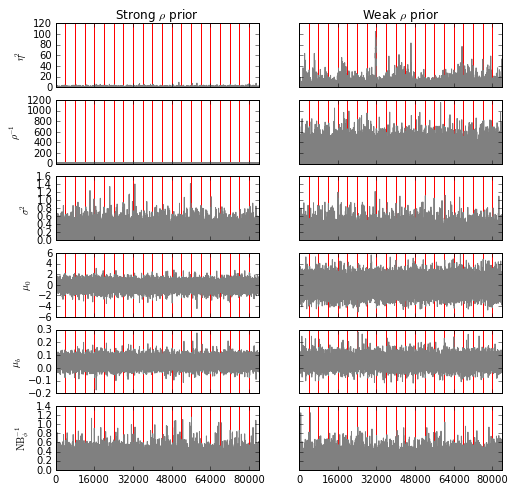

In [14]:
## Traceplot
trace_pars = [('eta_sq','$\\eta^2$'),
	      ('inv_rho','$\\rho^{-1}$'),
	      ('sigma_sq','$\\sigma^2$'),
	      ('mu_0','$\\mu_0$'),
	      ('mu_b','$\\mu_b$'),
	      ('NB_phi_inv','$\\rm{NB}_\\phi^{-1}$')]
fig,axs = plt.subplots(len(trace_pars),2, figsize=(8,8), sharex='all', sharey='row')
exts = [stan_model_ext_rho_strong, stan_model_ext_rho_weak]
exts_names = [r'Strong $\rho$ prior', r'Weak $\rho$ prior']
for j in range(2):
    axs[0,j].set_title(exts_names[j])
    for i,par in enumerate(trace_pars):
        axs[i,j].plot(exts[j][par[0]], color='.5')
        if j==0: axs[i,j].set_ylabel(par[1])
        for k in range(1, Nchains+1):
            axs[i,j].axvline(Niter/2 * k, c='r', zorder=-1)

    axs[len(trace_pars) - 1,j].set_xticks(np.arange(0, (Niter/2)*Nchains+1, Niter*2))


We assess MCMC convergence quantitatively using the Gelman-Rubin convergence diagnostic, $\hat{R}$, a comparison of within- to between-chain variance.  We find that $\hat{R} \ll 1.05$ for all parameters, indicating a negligable discrepancy in the sampling distributions between chains.


In [15]:
def read_stansummary(path, cmdstan_path=cmdstan_path):
    """
    Wrapper for the cmdstan program stan_summary to calculate
    sampling summary statistics across multiple MCMC chains.
    
    Args:
        path (str): Path, with a wildcard (*) for the id number
        of each output chain
        
        cmdstan_path (str): Path to the stan home directory
    
    Returns:
        out: A pandas dataframe with the summary statistics provided 
        by stan_summary.  Note that each element of array variables
        are provided on separate lines
    """
    from StringIO import StringIO
    summary_string = subprocess.check_output(cmdstan_path + 'bin/stansummary --sig_figs=5 '+path, shell=1)
    out = pd.read_table(StringIO(summary_string), sep='\s+', header=4, skip_footer=6, engine='python')
    return out

## Use cmdstan's stansummary command to calculate rhat
stan_model_sum_rho_strong = read_stansummary('output_cmdstan_gp_rhostrong*.csv')
stan_model_sum_rho_weak = read_stansummary('output_cmdstan_gp_rhoweak*.csv')

(0.99, 1.06)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


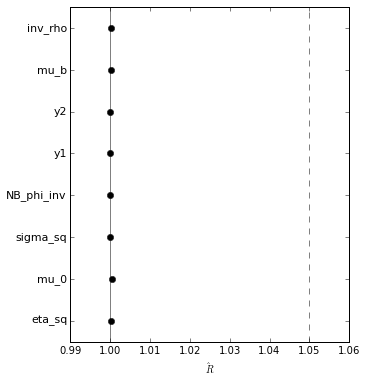

In [16]:
## Get summary statistics using pystan
#model_summary = stan_model_samp_rho_strong.summary()
#Rhat_vec = model_summary['summary'][:,array(model_summary['summary_colnames'])=='Rhat']
#pars = model_summary['summary_rownames']

## Get summary statistics using cmdstan wrapper
model_summary = stan_model_sum_rho_strong
Rhat_vec = stan_model_sum_rho_strong['R_hat'].values
pars = stan_model_sum_rho_strong.index

## Replace y1, y2 with summaries
sel_pars = ['y1', 'y2', u'eta_sq', u'inv_rho', u'sigma_sq', u'mu_0', u'mu_b', 'NB_phi_inv']
Rhat_dic = {}
for spar in sel_pars:
	if spar in ('y1','y2'):
		sel = np.where([True if p.startswith(spar) else False for p in pars])
		Rhat_dic[spar] = np.percentile(Rhat_vec[sel], [5,50,95])
	else:
		Rhat_dic[spar] = [Rhat_vec[[pars==spar]],]*3

plt.figure(figsize=(5,6))
plt.errorbar(np.array(Rhat_dic.values())[:,1], np.arange(len(sel_pars)), \
	xerr= [np.array(Rhat_dic.values())[:,1] - np.array(Rhat_dic.values())[:,0],\
		np.array(Rhat_dic.values())[:,2] - np.array(Rhat_dic.values())[:,1]],\
	capsize=0, marker='o', color='k', lw=0)
plt.yticks(np.arange(len(sel_pars)), Rhat_dic.keys(), size=11)
plt.xlabel('$\hat{R}$')
plt.axvline(1.0, color='.5', ls='solid', zorder=-2)
plt.axvline(1.05, color='.5', ls='dashed', zorder=-2)
plt.ylim(-.5, len(sel_pars)-.5)
plt.xlim(0.99, 1.06)

## Posterior Simulations and Predictive Checks

To assess goodness of fit, we inspect simulated draws of the Gaussian process from the posterior and perform posterior predictive checks.

### Simulated draws

First we perform a posterior predictive check by visualizing the sampled values of $z$, which realizes both a draw from the latent Gaussian process for the mass shootings rate and the overdispersed counting noise of the negative binomial distribution.

84000
8000


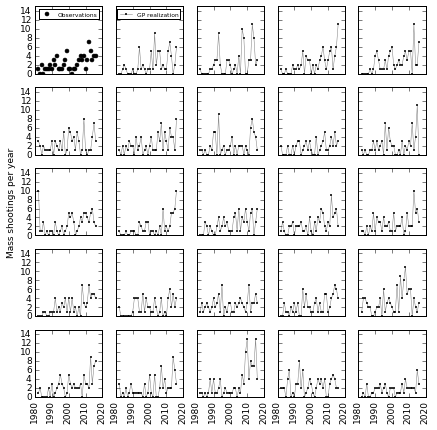

In [17]:
N_samp = Niter / 2
print len(stan_model_ext_rho_strong['z_rep'])
print Niter

fig, axs = plt.subplots(5,5, figsize=(7,7), sharex='all', sharey='all')
po = axs[0,0].plot(data_years, stan_data['z1'], 'o', c='k', mfc='k', label='Observations', zorder=2, lw=1, ms=4)
axs[0,0].legend(numpoints=1, prop={'size':6})
for i in range(1,25):
	draw = np.random.randint(0, N_samp)
	py = stan_model_ext_rho_strong['z_rep'][draw][:stan_data['N1']]
	axs.flatten()[i].plot(data_years, py,  mfc='k', marker='o',
	  lw=.5, mec='none', ms=2, color='.5', label='GP realization')
axs[0,1].legend(numpoints=1, prop={'size':6})
axs[0,0].set_ylim(0,15)
axs[0,0].set_xticks([1980, 1990, 2000, 2010, 2020])
for ax in axs.flatten(): 
	plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=9)
	plt.setp(ax.get_yticklabels(), fontsize=9)

axs[2,0].set_ylabel('Mass shootings per year', size=9)


Visual inspection suggests that the observations simulated under the model show similar variation over time as the actual observations (first panel).  We note that some realizations have annual counts at the later end of the modeled time range that exceed the largest observed annual count (7 mass shootings).  Some exceedence is expected given the counting noise, but this posterior predictive check could guide revision of the prior on the over-dispersion parameter or the choice of the negative binomial likelihood. 

Because the relative variance in the annualized counting statistics is high (i.e. mass shootings are generally infrequent on an annual basis), it is also helpful to examine the model for the underlying shooting rate in detail.  Next we plot the posterior distribution of the Gaussian process for the annualized mass shooting rate simulated across a grid of timepoints subsampled between years and extending beyond the current year (2016), effectively interpolating and extrapolating from the observations.

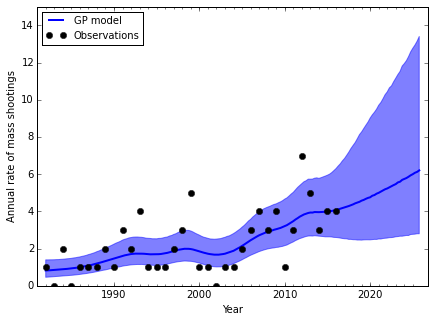

In [18]:
def plot_GP(stan_model_ext):
    y2_sum = np.percentile(np.exp(stan_model_ext['y2']), [16,50,84], axis=0)
    plt.figure(figsize=(7,5))
    pfb = plt.fill_between(data_years_samp, y2_sum[0], y2_sum[2], color='b', alpha=.5)
    pfg = plt.plot(data_years_samp, y2_sum[1], c='b', lw=2, label='GP model', zorder=0)
    po = plt.plot(data_years, stan_data['z1'], 'o', c='k', label='Observations', zorder=2)
    plt.xlabel('Year')
    plt.ylabel('Annual rate of mass shootings')
    plt.legend(prop={'size':10}, loc=2)
    plt.ylim(0,15)
    plt.gca().xaxis.set_minor_locator(FixedLocator(np.arange(min(data_years_samp), max(data_years_samp))))
    plt.gca().set_xlim(min(data_years_samp) - 1, max(data_years_samp) + 1)
    return pfb, pfg, po

pfb, pfg, po = plot_GP(stan_model_ext_rho_strong)

The Gaussian process captures an increase in the mass shooting rate over the decades and some fluctuations against that trend during certain periods, as we will explore in more detail below.  The model does not show any visually apparent deviations from the evolution of the observational time series, although comparison to the data highlights several years with substantially outlying mass shooting totals (e.g. 1993 and 1999).  The extrapolated period ($>2016$) suggests a range of outcomes spanning increases and decreases in the annual mass shooting rate from the 2016 level.

We add random draws from the mean function to visualize our inferences on the long-term time evolution of the mass shooting rate.

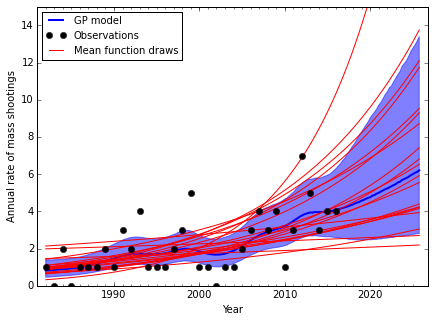

In [19]:
def plot_GP_mu_draws(stan_model_ext):
    plot_GP(stan_model_ext)
    N_samp = len(stan_model_ext['mu_0'])
    px = np.linspace(min(data_years_samp), max(data_years_samp), 100) 
    pfms = []
    for i in range(20):
        draw = np.random.randint(0, N_samp)
        py = np.exp(stan_model_ext['mu_0'][draw] + (px - min(data_years)) * stan_model_ext['mu_b'][draw])
        pfms.append(plt.plot(px, py,  c='r', 
          zorder = 1, label = 'Mean function draws' if i==0 else None))
    plt.legend(prop={'size':10}, loc=2)

plot_GP_mu_draws(stan_model_ext_rho_strong)

The comparison between draws of the mean functions (red) and the model posterior (blue) suggests that the mean function captures most of the modeled variation in the shooting rate over time.  

We can understand the behavior of the Gaussian process covariance function by isolating it from the mean function.  We do so by subtracting the linear component of the mean function from the simulated Gaussian process rates ($y_2$) and plotting against the observations.

(1981.0, 2026.75)

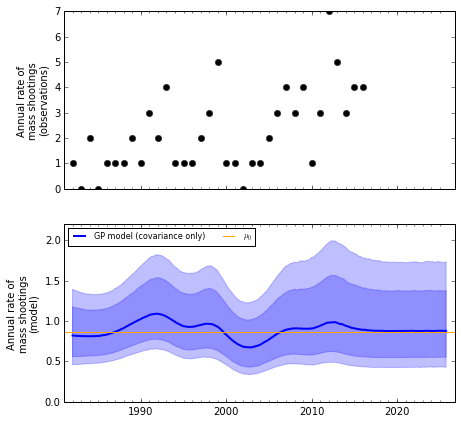

In [20]:
y2_gp_rho_strong = np.percentile(np.exp(
        stan_model_ext_rho_strong['y2'] - 
        np.dot(stan_model_ext_rho_strong['mu_b'][:,np.newaxis], (data_years_samp[np.newaxis,:] - min(data_years)))
          ), [16,25,50,75,84], axis=0)

fig, axs = plt.subplots(2, figsize=(7,7), sharex='all')
pfb = axs[1].fill_between(data_years_samp, y2_gp_rho_strong[1], y2_gp_rho_strong[3], color='b', alpha=.25)
pfb2 = axs[1].fill_between(data_years_samp, y2_gp_rho_strong[0], y2_gp_rho_strong[4], color='b', alpha=.25)
pfg = axs[1].plot(data_years_samp, y2_gp_rho_strong[2], c='b', lw=2, label='GP model (covariance only)', zorder=0)
po = axs[0].plot(data_years, stan_data['z1'], 'o', c='k', label='Observations', zorder=2)
axs[1].axhline(np.exp(stan_model_ext_rho_strong['mu_0'].mean()), color='orange', label='$\mu_0$')

axs[0].set_ylabel('Annual rate of \nmass shootings\n(observations)')
axs[1].legend(prop={'size':8}, loc=2, ncol=2)
axs[1].set_ylabel('Annual rate of \nmass shootings\n(model)')

axs[1].set_ylim(0, 2.2)
axs[1].xaxis.set_minor_locator(FixedLocator(np.arange(min(data_years_samp), max(data_years_samp))))
axs[1].set_xlim(min(data_years_samp) - 1, max(data_years_samp) + 1)


In this plot, the shaded regions show the interquartile and $[16-84]$th percentile ranges.  The fact that the interquartile contours never cross the mean ($\mu_0$) indicates that there is never $>75\%$ probability that the annualized trend deviates from the linear mean function.  However, there are times when the interquartile range approaches the mean.  

Perhaps the most salient feature captured by the covariance function of the Gaussian process is a dip in the annualized rate of mass shootings in the years from about 2000 to 2005.  The model has no features that would seek to explain the causal origin of this dip, although many readers may be surprised by its juxtoposition with the Columbine High School massacre (1999), which is understood to have spawned dozens of "copycat" attacks over time (see e.g. Follman & Andrews 2015).

The largest positive deviation from the mean function occurs between  about 1988 and 1993.  During that time, the mean function itself is very small (see previous figure), so this does not reresent a large absolute deviation.

### Gaussian process with weak $\rho^{-1}$ prior

For comparison, we visualize the latent Gaussian process under a weak prior for $\rho^{-1}$.

(<matplotlib.collections.PolyCollection at 0x7f8392720f10>,
 [<matplotlib.lines.Line2D at 0x7f83926fc910>])

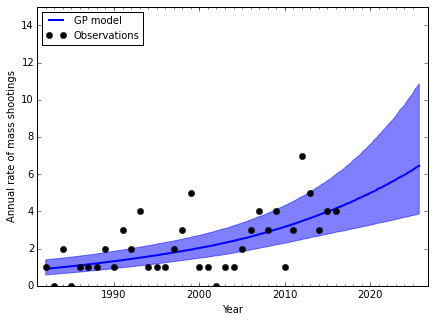

In [21]:
plot_GP(stan_model_ext_rho_weak)

It's clear from this visualization that the Gaussian process does not capture significant short-timescale variations when the timescale prior is loosened.  This model also generally expresses lower uncertainty in the annual mass shootings rate.  Consistent with the reliance on the parametric, linear mean function, the extrapolated predictions do not account for any substantial probability of decrease in the rate of mass shootings after 2016.

We can see the dominance of the mean function over the covariance function directly by again visualizing the isolated Gaussian process covariance function, which shows virtually no deviation from the mean:

(1981.0, 2026.75)

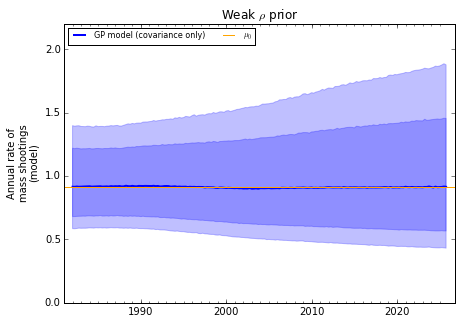

In [22]:
y2_gp_rho_weak = np.percentile(np.exp(
        stan_model_ext_rho_weak['y2'] - 
        np.dot(stan_model_ext_rho_weak['mu_b'][:,np.newaxis], (data_years_samp[np.newaxis,:] - min(data_years)))
          ), [16,25,50,75,84], axis=0)

fig, axs = plt.subplots(1, figsize=(7,5), sharex='all')
pfb = axs.fill_between(data_years_samp, y2_gp_rho_weak[1], y2_gp_rho_weak[3], color='b', alpha=.25)
pfb2 = axs.fill_between(data_years_samp, y2_gp_rho_weak[0], y2_gp_rho_weak[4], color='b', alpha=.25)
pfg = axs.plot(data_years_samp, y2_gp_rho_weak[2], c='b', lw=2, label='GP model (covariance only)', zorder=0)
axs.axhline(np.exp(stan_model_ext_rho_weak['mu_0'].mean()), color='orange', label='$\mu_0$')

axs.legend(prop={'size':8}, loc=2, ncol=2)
axs.set_ylabel('Annual rate of \nmass shootings\n(model)')
axs.set_title(r'Weak $\rho$ prior')

axs.set_ylim(0, 2.2)
axs.xaxis.set_minor_locator(FixedLocator(np.arange(min(data_years_samp), max(data_years_samp))))
axs.set_xlim(min(data_years_samp) - 1, max(data_years_samp) + 1)


## Inspection of posterior correlations

Before we explore the marginalized posterior distributions of the parameters in our model, we take advantage of the fully Bayesian posterior samples generated by the NUTS simulations to understand the correlations between parameters in the posterior distribution.

FIrst we note that the parameters of the linearized mean function are highly correlated:

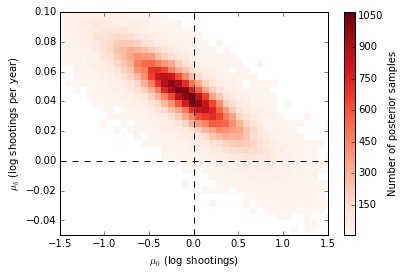

In [23]:
plt.figure()
pa = plt.hist2d(stan_model_ext_rho_strong['mu_0'], 
                stan_model_ext_rho_strong['mu_b'], 
                bins=100, cmap=cm.Reds, cmin=4)
plt.xlabel(r'$\mu_0$ (log shootings)')
plt.ylabel(r'$\mu_b$ (log shootings per year)')
plt.axvline(0, color='k', ls='dashed')
plt.axhline(0, color='k', ls='dashed')
plt.axis([-1.5,1.5,-0.05,.1])
cb = plt.colorbar()
cb.set_label('Number of posterior samples')


If the mean rate of mass shootings at the beginning of the time series ($\mu_0$) is inferred to be higher, then the increase in the mean function over time needed to explain the observations ($\mu_b$) would be lower.  However, at all probable values of $\mu_0$, the distribution of $\mu_b$ is predominantly positive.

We can fit a simple linear model to understand more subtle correlations in the multivariate posterior distribution.  Here we fit a model for $\rho^{-1}$ as a function of the other major parameters of the model.  We standardize the predictors so that we can directly compare the coefficients on the linear model.

In [24]:
import statsmodels.api as sm

## Assemble data matrices
y = pd.Series(stan_model_ext_rho_strong['inv_rho']); y.name = 'inv_rho'
X = pd.DataFrame({
	'eta':np.sqrt(stan_model_ext_rho_strong['eta_sq']), 
	'mu_0':stan_model_ext_rho_strong['mu_0'], 
	'mu_b':stan_model_ext_rho_strong['mu_b'], 
	'sigma':np.sqrt(stan_model_ext_rho_strong['sigma_sq']), 
	'NB_phi_inv':np.sqrt(stan_model_ext_rho_strong['NB_phi_inv']), 
	})
## Standardize
X = X - X.mean()
X = X / X.std()
X = sm.add_constant(X)
y = (y - y.mean()) / y.std()
## Fit linear model using stats models
est = sm.OLS(y, X).fit()
## Print summary
print est.summary2()

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.057      
Dependent Variable: inv_rho          AIC:                233491.9522
Date:               2016-12-01 01:39 BIC:                233547.9836
No. Observations:   84000            Log-Likelihood:     -1.1674e+05
Df Model:           5                F-statistic:        1009.      
Df Residuals:       83994            Prob (F-statistic): 0.00       
R-squared:          0.057            Scale:              0.94338    
----------------------------------------------------------------------
               Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
----------------------------------------------------------------------
const         -0.0000     0.0034   -0.0000   1.0000   -0.0066   0.0066
NB_phi_inv     0.0084     0.0034    2.4949   0.0126    0.0018   0.0150
eta            0.2373     0.0034   70.4585   0.0000    0.2307   0.2439
mu_0           0.0186     0.0062    3.01

We see that the most significant correlation is between $\rho^{-1}$ and $\eta$.  When we visualize this correlation, we observe that the level of posterior curvature associated with these two variables is small, though significant.

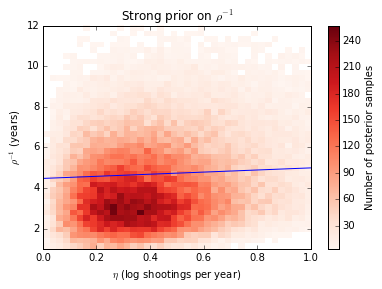

In [25]:
plt.figure()
pa = plt.hist2d(np.sqrt(stan_model_ext_rho_strong['eta_sq']), 
                stan_model_ext_rho_strong['inv_rho'], 
                bins=40, cmap=cm.Reds, cmin=4,
                range = [[0,1],[1,12]])
plt.xlabel(r'$\eta$ (log shootings per year)')
plt.ylabel(r'$\rho^{-1}$ (years)')
sqrt_eta = np.sqrt(stan_model_ext_rho_strong['eta_sq'])
px = np.linspace(min(sqrt_eta), max(sqrt_eta), 10)
px_std = (px - np.mean(sqrt_eta)) / np.std(sqrt_eta)
plt.plot(px, 
         # Constant term
         (est.params[est.model.exog_names.index('const')] + 
         # Linear term
         px * est.params[est.model.exog_names.index('eta')] 
         # Standardization adjustment
         * stan_model_ext_rho_strong['inv_rho'].std()) + stan_model_ext_rho_strong['inv_rho'].mean())

plt.axis()
cb = plt.colorbar()
cb.set_label('Number of posterior samples')
plt.title(r'Strong prior on $\rho^{-1}$')

When we explore the same correlation in the posterior of the model with a weak prior specified on the timescale hyperparameter, we see somewhat different results:

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.024      
Dependent Variable: inv_rho          AIC:                236366.4906
Date:               2016-12-01 01:39 BIC:                236422.5221
No. Observations:   84000            Log-Likelihood:     -1.1818e+05
Df Model:           5                F-statistic:        410.1      
Df Residuals:       83994            Prob (F-statistic): 0.00       
R-squared:          0.024            Scale:              0.97623    
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           -0.0000    0.0034   -0.0000  1.0000  -0.0067   0.0067
NB_phi_inv      -0.0053    0.0034   -1.5553  0.1199  -0.0120   0.0014
eta              0.1462    0.0034   42.5974  0.0000   0.1394   0.1529
mu_0             0.0235    0.0037    6.3891  0

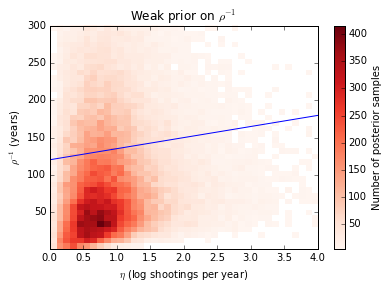

In [26]:
## Assemble data matrices
y = pd.Series(np.log(stan_model_ext_rho_weak['inv_rho'])); y.name = 'inv_rho'
X = pd.DataFrame({
	'eta':np.sqrt(stan_model_ext_rho_weak['eta_sq']), 
	'mu_0':stan_model_ext_rho_weak['mu_0'], 
	'mu_b':stan_model_ext_rho_weak['mu_b'], 
	'sigma':np.sqrt(stan_model_ext_rho_weak['sigma_sq']), 
	'NB_phi_inv':np.sqrt(stan_model_ext_rho_weak['NB_phi_inv']), 
	})
## Standardize
X = X - X.mean()
X = X / X.std()
X = sm.add_constant(X)
y = (y - y.mean()) / y.std()
## Fit linear model using stats models
est = sm.OLS(y, X).fit()
## Print summary
print est.summary2()

plt.figure()
pa = plt.hist2d(np.sqrt(stan_model_ext_rho_weak['eta_sq']), 
                stan_model_ext_rho_weak['inv_rho'], 
                bins=40, cmap=cm.Reds, cmin=4,
                range = [[0,4],[1,300]])
plt.xlabel(r'$\eta$ (log shootings per year)')
plt.ylabel(r'$\rho^{-1}$ (years)')
sqrt_eta = np.sqrt(stan_model_ext_rho_weak['eta_sq'])
px = np.linspace(min(sqrt_eta), max(sqrt_eta), 10)
px_std = (px - np.mean(sqrt_eta)) / np.std(sqrt_eta)
plt.plot(px, 
         # Constant term
         (est.params[est.model.exog_names.index('const')] + 
         # Linear term
         px * est.params[est.model.exog_names.index('eta')] 
         # Standardization adjustment
         * stan_model_ext_rho_weak['inv_rho'].std()) + stan_model_ext_rho_weak['inv_rho'].mean())

plt.axis()
cb = plt.colorbar()
cb.set_label('Number of posterior samples')
plt.title(r'Weak prior on $\rho^{-1}$')

Again, $\eta$ is the parameter most significantly correlated with $\rho^{-1}$, but now the 2D posterior visualization shows that this correlation is substantially non-linear.  In particular for the model with the weak prior on $\rho$, $\eta$ is constrained to much smaller values when the timescale $\rho^{-1}$ is small. In other words, in model draws that permit variations from the mean function on timescales smaller than the observational range ($\sim35$ years), the amplitude of those variations is constrained to be very small.  In any scenario, as we have seen, the importance of the covariance function is minimal under this prior.

## Parameter inferences

Below we show the marginalized posterior distributions of the parameters of the Gaussian process under the strong prior on $\rho$.

Strong prior on rho:


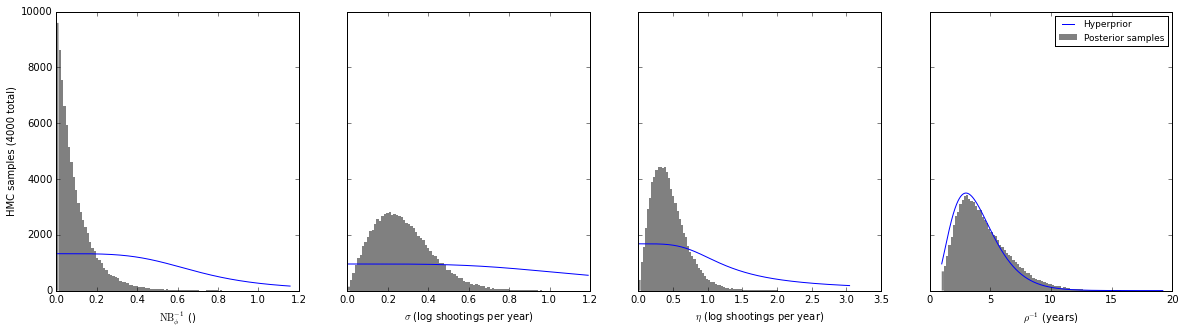

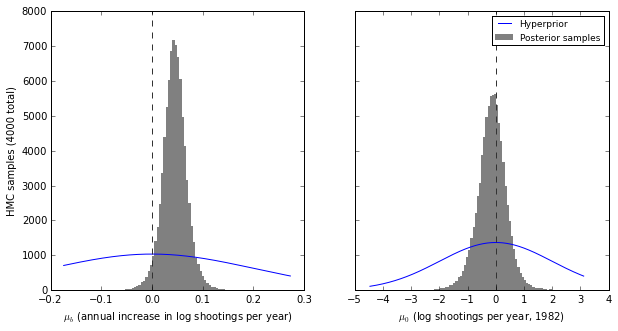

In [27]:
def gt0(y, x, lbound=0, ubound=np.inf):
	y[(x<lbound) & (x>ubound)] = 0
	return y

def marg_post_plot(stan_model_ext, alpha_rho, beta_rho, Nhist=25):
    hyp_dic = {
        'eta_sq': ('$\\eta$', np.sqrt, 'log shootings per year', lambda x: sstats.cauchy.pdf(x**2, 0, 1)),
        'inv_rho': ('$\\rho^{-1}$', lambda x: x, 'years', lambda x: gt0(sstats.gamma.pdf(x, alpha_rho, scale=beta_rho), x, lbound=1)),
        'sigma_sq': ('$\\sigma$', np.sqrt, 'log shootings per year', lambda x: sstats.cauchy.pdf(x**2, 0, 1)),
        'NB_phi_inv':('$\\rm{NB}_\\phi^{-1}$', lambda x:x, '', lambda x: sstats.cauchy.pdf(x**2, 0, 0.5)),
        }

    meanfunc_dic = {
        'mu_0': ('$\\mu_0$', lambda x: x, 'log shootings per year, '+str(np.min(data_years)), lambda x: sstats.norm.pdf(x, 0,2)),
        'mu_b': ('$\\mu_b$', lambda x: x, 'annual increase in log shootings per year', lambda x: sstats.norm.pdf(x, 0,0.2)),
        }

    for name,pdic in (('hyper', hyp_dic), ('meanfunc', meanfunc_dic)):
        fig,axs = plt.subplots(1,len(pdic), figsize=(5*len(pdic), 5), sharey='all')
        axs[0].set_ylabel('HMC samples ({} total)'.format(N_samp))
        for i,hyp in enumerate(pdic.keys()):
            samps = pdic[hyp][1](stan_model_ext[hyp])
            hn, hb, hp = axs[i].hist(samps, Nhist, edgecolor='none', facecolor='.5', label='Posterior samples')
            ppx = np.linspace(np.min(samps), np.max(samps), 10000)
            ppy = pdic[hyp][1]( pdic[hyp][3](ppx) )
            ## Normalize
            #ppy *= np.percentile(hn, 80) / np.max(ppy)
            ppy *= len(samps) / np.sum(ppy) * len(ppy) / len(hn)
            axs[i].plot(ppx, ppy, color='b', zorder=2, label='Hyperprior')
            axs[i].set_xlabel(pdic[hyp][0] + ' ({})'.format(pdic[hyp][2]))
            axs[i].axvline(0, ls='dashed', color='.2')
        axs[-1].legend(prop={'size':9})

print "Strong prior on rho:"
marg_post_plot(stan_model_ext_rho_strong, stan_data_rho_strong['alpha_rho'], 1/stan_data_rho_strong['beta_rho'], Nhist=100)

The comparison of the posterior and prior distributions show strong evidence from the data to identify most hyperparameters.  The posterior for $\mu_0$ shows a concentration around a baseline rate of $\exp(-1)\sim0.4$ to $\exp(1)\sim 3$ mass shootings per year at the start of the dataset, 1982, reflecting a variance, much smaller than the corresponding prior.  The negative binomial overdispersion parameter ($\phi^{-1}$) is concentrated towards very small values $\ll 1$, indicating that the Poisson disitrubtion is a good approximation to the variance in the observations.  The amplitude of the Gaussian process covariance function, $\eta$, is strongly shifted from the mode of the prior distribution, to a mean of $\exp(0.5)\sim1.6$ mass shootings per year.  The variance of the Gaussian process covariance function, $\sigma$, has a posterior variance much smaller than the prior distribution.

The posterior distribution of $\rho^{-1}$ is a notable exception.  It shows no visual deviation from the prior distribution, indicating that this parameter is not identified by the observations.

Next we explore the same marginalized posteriors under the weak prior on $\rho$.

Weak prior on rho:


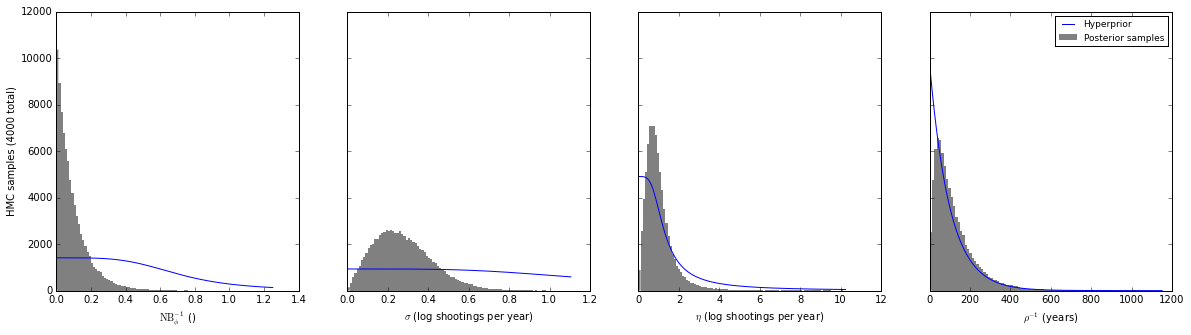

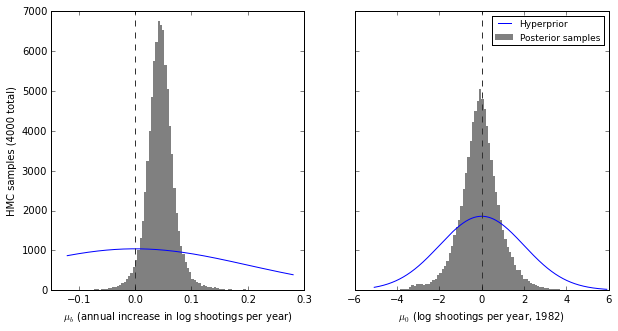

In [28]:
print "Weak prior on rho:"
marg_post_plot(stan_model_ext_rho_weak, stan_data_rho_weak['alpha_rho'], 1/stan_data_rho_weak['beta_rho'], Nhist=100)

With the weak prior on $\rho$, most parameters have posterior distributions nearly identical to their distributions under the strong prior on $\rho$.  In particular, the conclusions about the mean function parameters ($\mu_0$ and $\mu_b$), $\phi$, and $\sigma$ seem robust to the choice of prior.  

Importantly, the $\rho$ parameter is again largely non-identified.  Its posterior distribution generally follows the weaker prior, although it shows a posterior probability less than the prior for the very smallest values.  The consequence is that the models sampled from the Gaussian process have very long timescales for their covariance function.  The distribution of the amplitude, $\eta$, is skewed to larger values under the weaker prior, although the amplitude of the mean function has little consequence when the time variation is negligable (as discussed in the previous section).

## Model predictions

We calculate the posterior probability that the annualized rate of mass shootings has increased in the US since 1982 ($\mu_b > 0$).

In [29]:
print_ext_names = ['...with strong prior on rho: ', '...with weak prior on rho: ']

print 'p(mu_b > 0):'
for i in range(2):
    print print_ext_names[i]+'%0.0f'%(np.mean(exts[i]['mu_b'] > 0)*100)+'%'
    

p(mu_b > 0):
...with strong prior on rho: 97%
...with weak prior on rho: 97%


This indicates strong statistical evidence for a long term increase in the annualized rate of mass shootings over the past three decades, regardless of our choice of prior for the timescale parameter, $\rho$.  In linear terms, the mean percentage increase in the rate of mass shootings is found to be,

In [30]:
zincreaseraw = {}
for i in range(2):
    zincreaseraw[i] = (np.exp((2016 - np.min(data_years)) * exts[i]['mu_b']) - 1) * 100
    zincrease = np.percentile(zincreaseraw[i], [16,50,84])
    print print_ext_names[i]+'%0.0f'%round(zincrease[1], -1)+'^{+%0.0f'%round(zincrease[2]-zincrease[1], -1)+'}_{-%0.0f'%round(zincrease[1]-zincrease[0], -1)+'}'


...with strong prior on rho: 360^{+500}_{-230}
...with weak prior on rho: 360^{+480}_{-230}


While the uncertainty interval is large, the $1\sigma$ estimate suggests at least a doubling in the annualized rate of mass shootings over these three decades, and more likely a quadrupling or greater increase.

For comparison, the US population has grown from $\sim231$ million to $318$ million residents according to [worldbook data](http://data.worldbank.org/indicator/SP.POP.TOTL?cid=GPD_1), an increase of $38\%$, over that same period.  The model posterior suggests that the rate of mass shootings has surpassed the rate of population growth with very high confidence:

In [31]:
for i in range(2):
    print print_ext_names[i]+'%0.0f'%(np.mean(zincreaseraw[i] > 38)*100)+'%'

...with strong prior on rho: 94%
...with weak prior on rho: 94%


Cohen et al. (2014) reported a tripling in the rate of mass shottings between 2011 and 2014 on the basis of a SPC methodology.  Our inference on the mean function of the Gaussian process, because it is parameterized as linear over the full time extent of the modeled period, does not directly address this claim.  But the simulated predictions of the Gaussian process, including the covariance component, can generate relevant comparisons.

Probability of increase:  58 %
Mean factor of predicted increase:  1.3 X
Probability of increase by at least 3X:  0.03 %


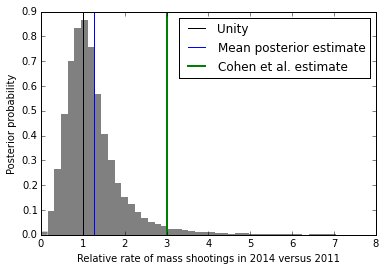

In [32]:
i1 = np.argmin(abs(data_years_samp - 2011.5))
i2 = np.argmin(abs(data_years_samp - 2014.5))
py = np.exp(stan_model_ext_rho_strong['y2'][:,i2]) / np.exp(stan_model_ext_rho_strong['y2'][:,i1])

plt.figure()
ph = plt.hist(py, 50, edgecolor='none', facecolor='.5', range=[0,8], normed=1)
plt.xlabel('Relative rate of mass shootings in 2014 versus 2011')
plt.ylabel('Posterior probability')
plt.axvline(1, color='k', label='Unity')
plt.axvline(np.mean(py), color='b', label='Mean posterior estimate')
plt.axvline(3, color='g', label='Cohen et al. estimate', lw=2)
plt.legend()

print "Probability of increase: ", '%0.0f'%(np.mean(py > 1) * 100), '%'
print "Mean factor of predicted increase: ", '%0.1f'%(np.mean(py)), 'X'
print "Probability of increase by at least 3X: ", '%0.2f'%(np.mean(py > 3)), '%'

While we have reported that the increase in the rate of mass shootings over the past three decades is likely to be a factor of several, we find much less evidence for such a dramatic increase over the time period from 2011 to 2014. As reported above, our model predicts better than even odds that there was an increase during that three year period, but the odds that it was as high as a tripling are exceedingly small. Our model suggests that the increase was more likely to be $\sim30\%$ .

## Conclusions

We have used Stan to implement and estimate a negative binomial regression model for the annualized rate of mass shootings in the United States based on a Gaussian process with a time-varying mean function.  When combined with a strong prior on the timescale of the Gaussian process covariance function, this design yields a predictive model with the full non-parametric flexibility of a Gaussian process to explain short timescale variation, while retaining the clear interpretability of a parametric model by isolating and jointly modeling long-term (timescale of decades) evolution in the shooting rate.  Applying this model to the Mother Jones database of US mass shootings, our major conclusions are as follows,

* We use posterior simulations and predictive checks to demonstrate the efficacy of the Gaussian process model in generating and fitting the observations of the annual mass shooting rate from the Mother Jones database.  We explore the effects of prior choices on the posterior and visualize posterior curvature between hyperparameters.
* We use the non-parametric Gaussian process predictive model to identify an apparent dip in the mass shooting rate in the first few years of the new millenium.
* With a 97% probability, we find that the annualized rate of mass shootings has risen over the past three decade.  This finding is robust to the choice of prior on the timescale parameter.
* The posterior mean estimate for the increase in the shooting rate since 1982 is $\sim300\%$.
* We compare to an independent, 2014 analysis of the increase in the rate of mass shootings between 2011 and 2014 by Cohen et al.  Our model predicts a smaller rate of increase for the underlying rate of mass shootings over this period than the SPC approach applied by authors, closer to 30% over the 4 year period.

## References
* Betancourt & Girolami 2013: Michael Betancourt &  Mark Girolami 2013, [Hamiltonian Monte Carlo for Hierarchical Models](https://arxiv.org/abs/1312.0906)
* Cohen et al. 2014: Amy Cohen et al. 2014, [Rate of Mass Shootings Has Tripled Since 2011, Harvard Research Shows](http://www.motherjones.com/politics/2014/10/mass-shootings-increasing-harvard-research)
* Follman & Andrews 2015: Mark Follman and Becca Andrews 2015, [How Columbine Spawned Dozens of Copycats](http://www.motherjones.com/politics/2015/10/columbine-effect-mass-shootings-copycat-data)
* Fox & Levin 2015: James Alan Fox and Jack Levin 2015, Mass confusion concerning mass murder, The Criminologist, Vol. 40, No. 1
* Lott 2014: John R. Lott 2014, [The FBI's Misrepresentation of the Change in Mass Public Shootings](http://dx.doi.org/10.2139/ssrn.2524731)
* Papaspiliopoulos et al. 2003: Non-Centered Parameterisations for Hierarchical Models and Data Augmentation in Bayesian Statistics 7, Oxford University Press, p. 307–326.
* Rasmussen & Williams 2006: Carl Edward Rasmussen & CKI Williams 2006, [Gaussian processes for machine learning](http://www.gaussianprocess.org/gpml/)
* Roberts et al. 2012: S. Roberts et al 2012, [Gaussian processes for time-series modelling](http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf)
* *Stan* Manual: [Stan Modeling Language Users Guide and Reference Manual](http://mc-stan.org/), Version 2.8.0